# Neon Filter

This notebook demostrates the use of PYNQ to communicate with hardware accelerated neon filter/colour edge.

<img src="assets/SystemIP.JPG", width = 700, height = 200>

The bitstream was created using Vivado following the desing methodology presented in Tutorial 4, however, using the NeonAXITemplate.slx model created base on David Northcote's Sobel filter design.

## Handling images in Python

Using Craig Ramsay's Jupyter notebook example to create this notebook.

  1. `PIL` (Python Image Library) for most of the image handling
  2. `Numpy` for support for fast, statically-typed, fixed-length buffers. This is useful for performance when working with large images, but also for streaming these images to and from fixed-point hardware.
  

In [1]:
from PIL import Image
import numpy as np

JPG from SD, backgarden Robins this time.

In [4]:
image_raw = Image.open("assets/Robins.JPG")

Display Image

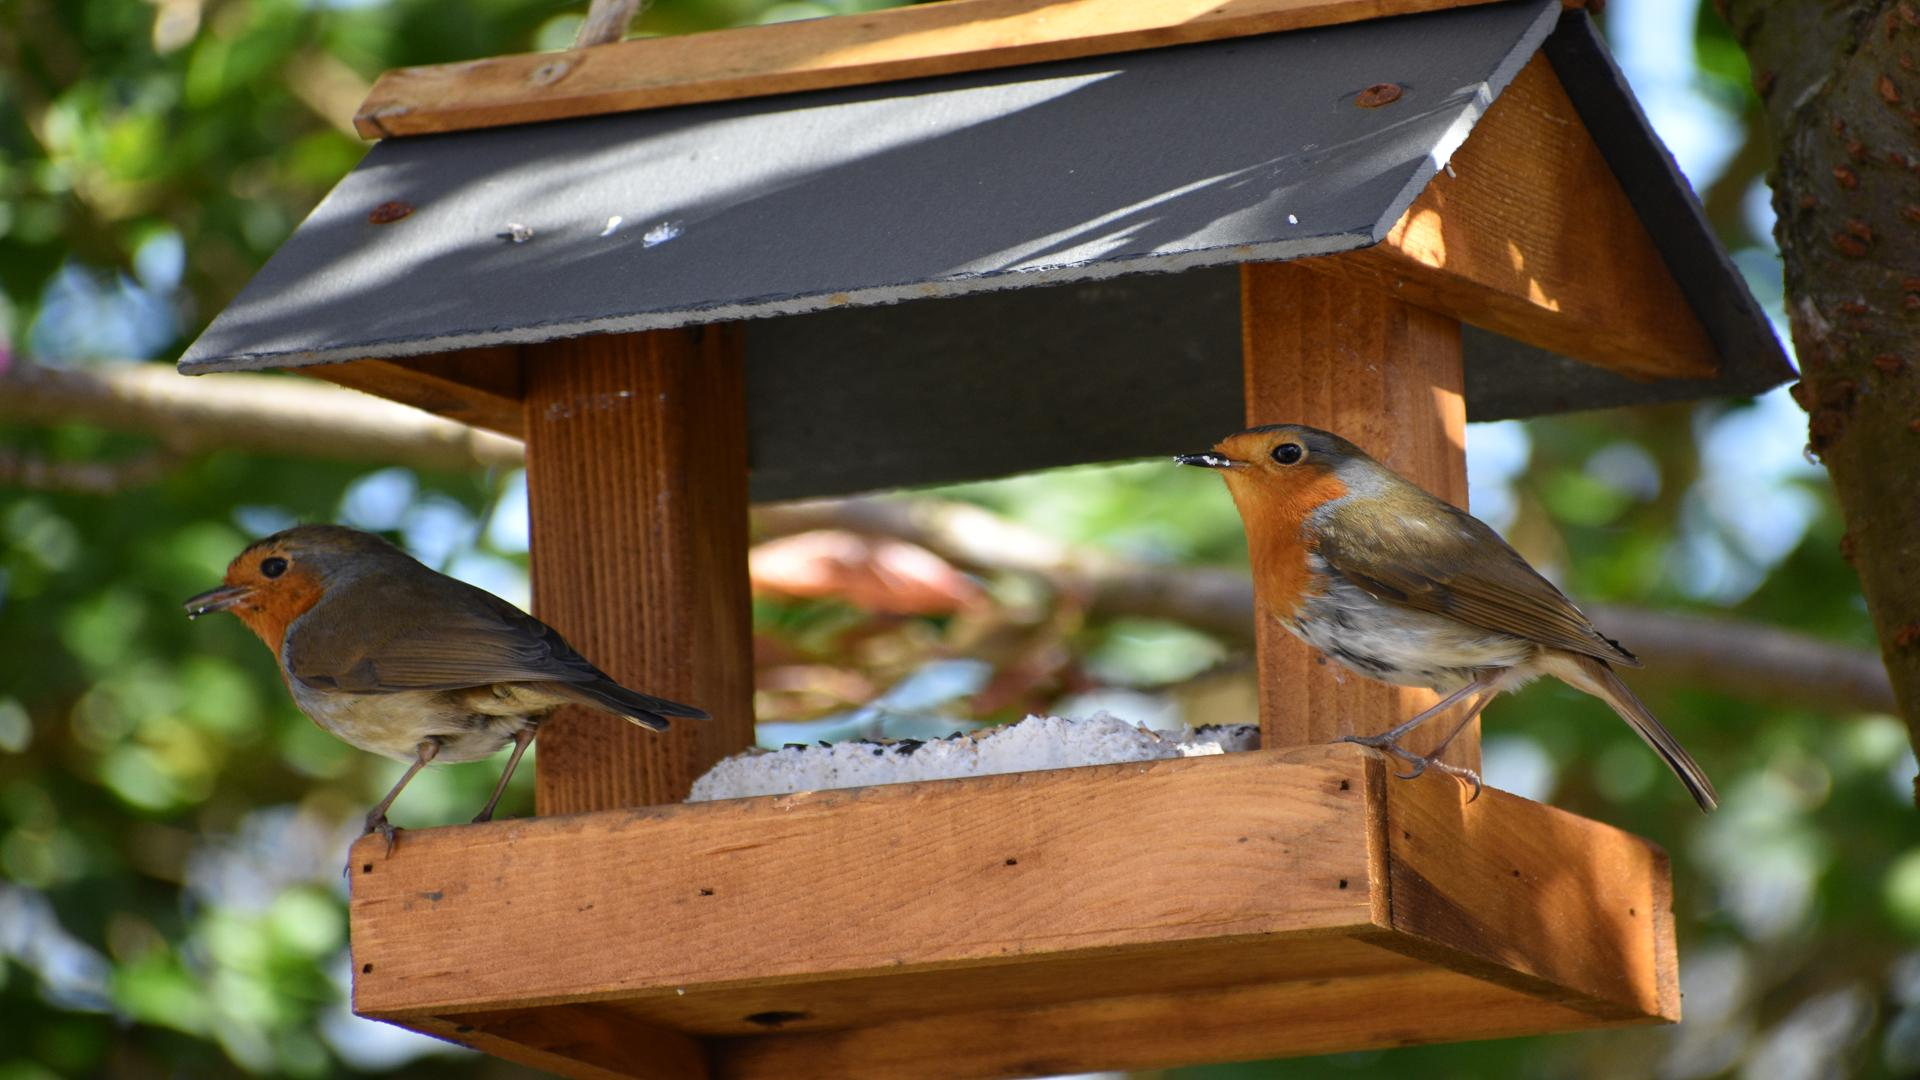

In [5]:
image_raw

## Formatting the image for hardware

The sobel filter example has some expectations about the image data:

  * The image should be 1920*1080 pixels (That's why it's a bit squished    looking)
  * Each pixel should be 32 bits
    + 8 bits for red
    + 8 bits for green
    + 8 bits for blue
    + and the remaining 8 bits are unused --- they are only there to pad the pixel out to 32 bits (the natural width of the AXI interface we're using between the PS and PL)
  * The image should then be padded to have one extra pixel all the way around the image's circumference. This is to allow local filtering to be done all the way to the extremes of the original image.

In [6]:
IMG_SIZE = (1920,1080) 

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

Again, let's see if we can display the image.

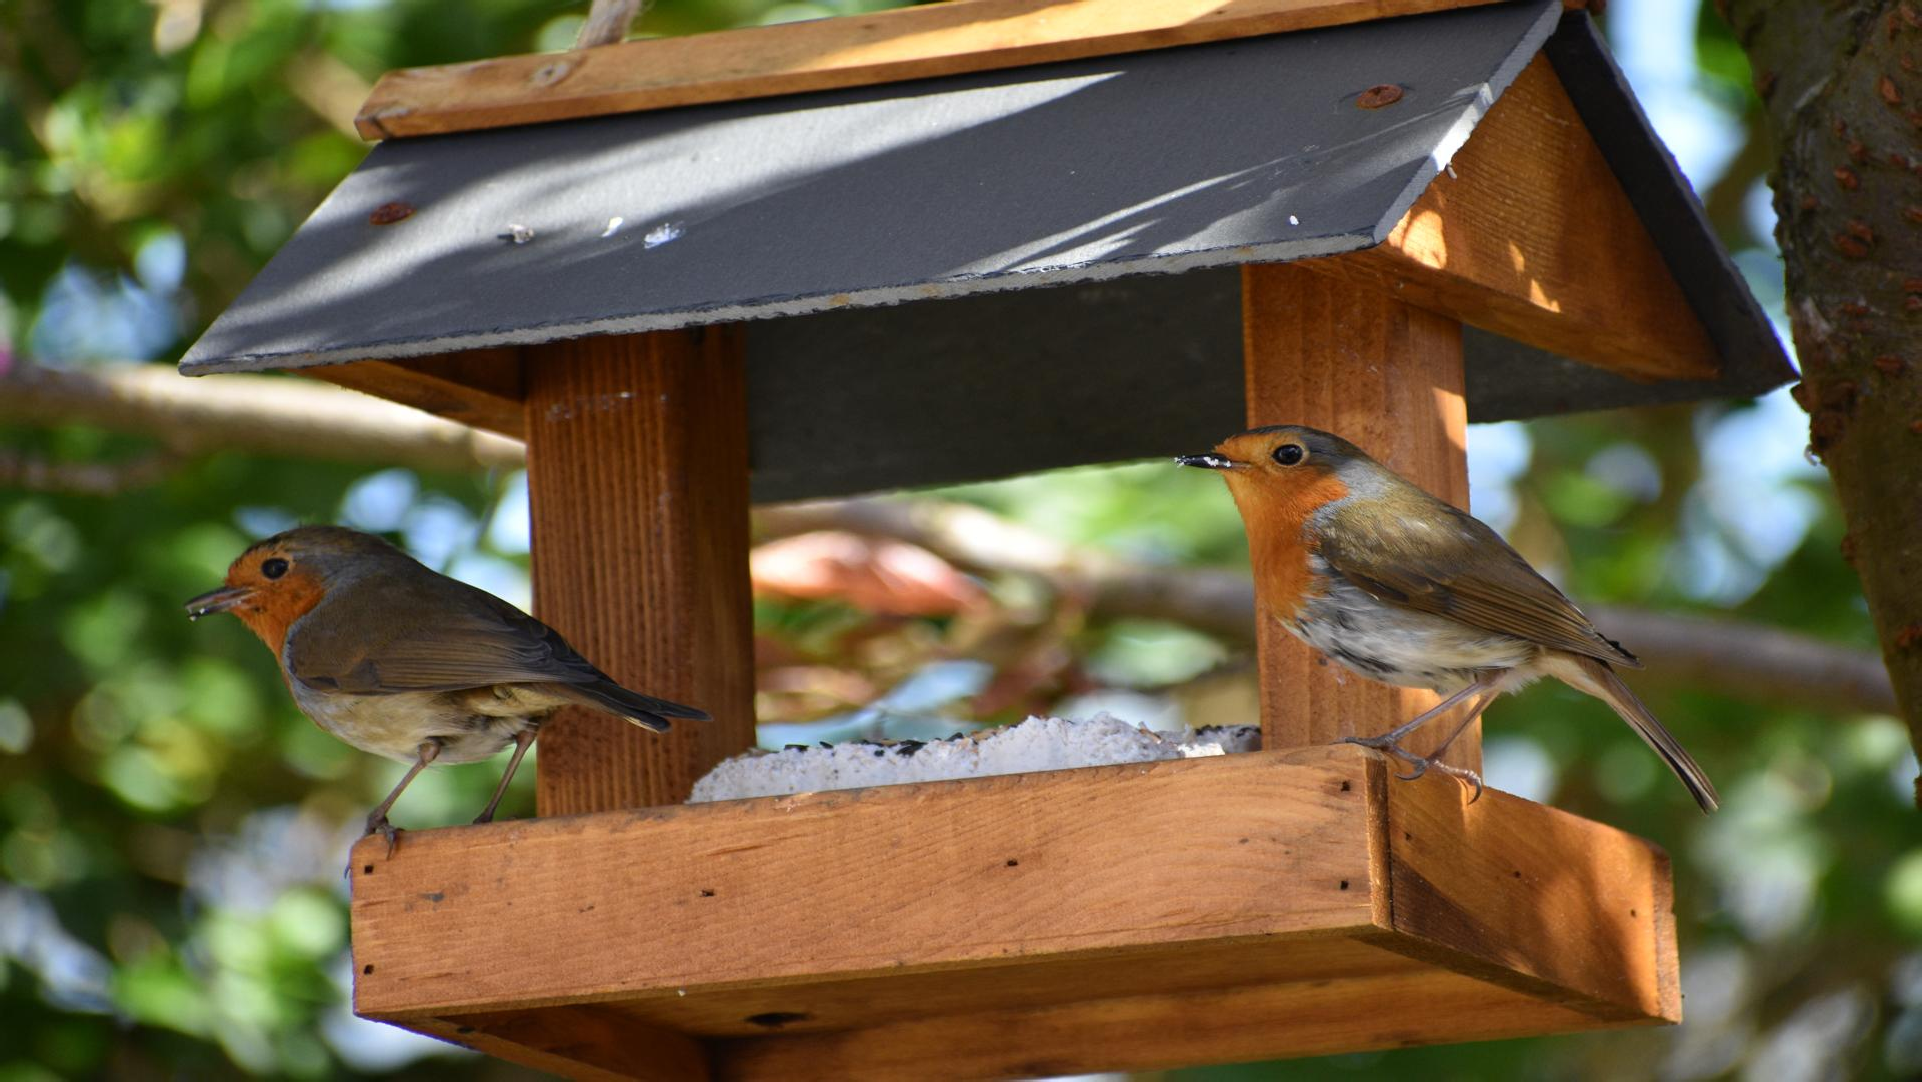

In [7]:
Image.fromarray(image_array_padded, 'RGB')

As the image is now in the correct format we can communicate with the Sharpen filter on the hardware.    
Note: This image was already resized to the notebook requirments externally but can just as easily been done via the notebook to implement any image size.

In [8]:
from pynq import Overlay
from pynq import Xlnk

overlay = Overlay("bitstream/design_1_wrapper.bit")

In [9]:
overlay?

In [10]:
dma = overlay.axi_dma

Reserve the buffers of the correct size for one input image (with padding) and one output (without padding).

We model the input image as a 3 dimensional array again, but this time we expand the last dimension from a size of 3 (R, G, or B) to 4. This introduces a space for the 8 bit padding required to ensure every pixel aligns to 32 bit boundaries.

As our filter is working on a colour image we have to include a 3D array for the output buffer. This is different from the Sobel Example.

In [11]:
# Make an Xlnk instance to control memory allocation
xlnk = Xlnk()

# Input array for DMA use
in_dma_array  = xlnk.cma_array(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
out_dma_array = xlnk.cma_array(shape=(IMG_SIZE[1],IMG_SIZE[0],4), dtype=np.uint8)

Let's define a function to take an image (as a numpy array) and then return the image that has been processed by the PL.

We don't have any AXI ( memory mapped) registers that can be written to so that simplifies our function somewhat.

We'll need to copy the image array into one of the (physically contiguous) DMA buffers we have allocated above before streaming it. Then we can use PYNQ's DMA transfer(..) and wait(...) functions to stream data to and from the Sharpen filter IP. 


In [14]:
def do_neon(image_array):
    
    # Copy image array into dma buffer
    in_dma_array[:, :, :3] = image_array[:, :, :]
       
    # Perform DMA transfers in both directions
    dma.recvchannel.transfer(out_dma_array)
    dma.sendchannel.transfer(in_dma_array)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # Return processed image array from PL 
    return out_dma_array

In [15]:
image_output = do_neon(image_array_padded)

# Display Image

"Image.fromarray(image_output[:, :, :3], mode='RGB')" where of [:, :, :3] is  shorthand for "Take all of the rows, take all of the columns, and only take the first 3 colour components (i.e., everything but the padding)" - Craig Ramsay

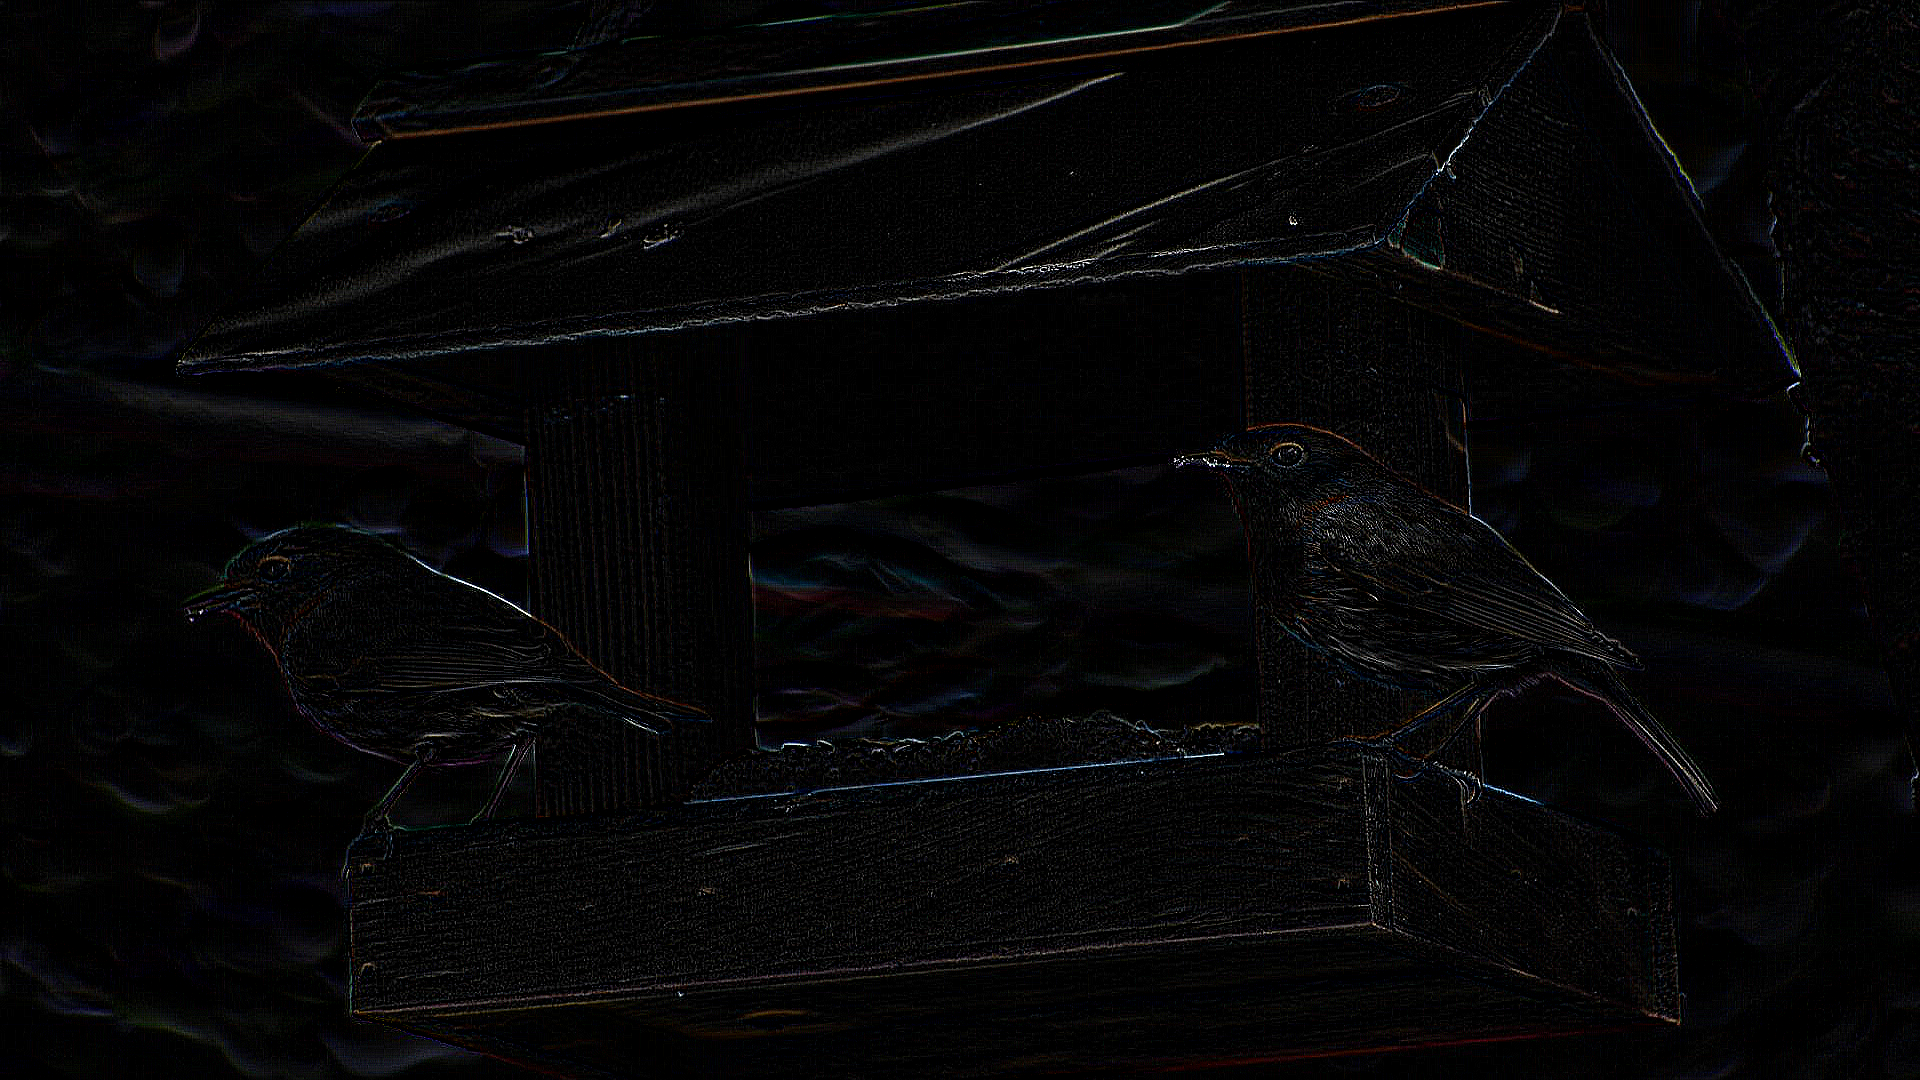

In [16]:
Image.fromarray(image_output[:, :, :3], mode='RGB')